# 主力籌碼影響價格分析

本篇主要分析三大主力:

1. 外資
2. 投信
3. 自營商

三個主力分別對於市場價格有甚麼影響

### 匯入股票價格

In [82]:
import yfinance as yf
import matplotlib.pyplot as plt

In [83]:
# 定義股票代碼和日期範圍
stock_code = "2330.TW"
start_date = "2021-01-01"
end_date = "2024-06-26"

# 獲取股價數據
yf_df = yf.download(stock_code, start=start_date, end=end_date)

# 計算價格百分比成長率
price_pct_groth = yf_df['Close'].pct_change().fillna(0)
yf_df["price_cum_growth"] = (1 + price_pct_groth).cumprod() - 1

[*********************100%%**********************]  1 of 1 completed


顯示圖表

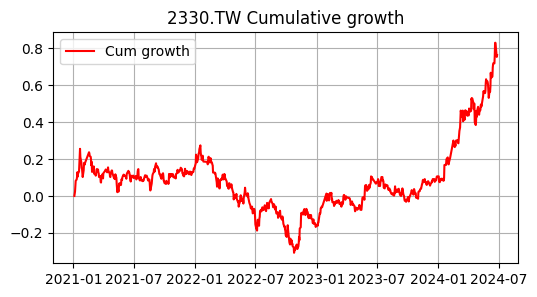

In [84]:
plt.figure(figsize=(6, 3))

plt.plot(yf_df.index, yf_df["price_cum_growth"] , color='red', label='Cum growth')
plt.title(f'{stock_code} Cumulative growth')
plt.legend()
plt.grid(True)
plt.show()

### 匯入主力籌碼變化

從 TWSE api 爬取時間區間的每日法人買賣資訊

In [5]:
import requests
import pandas as pd
from datetime import datetime, timedelta

In [17]:
# TODO : 將 stock_code 改成一個 list 或 tuple 抓取所有的股票資訊
def get_mi_movement_from_twse(start_date:str, end_date:str, stock_code:str) -> pd.DataFrame:

    """Get major investors movements dataframe during date"""

    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    result_df = pd.DataFrame()

    current_date = start
    while current_date <= end:
        try:
            date_str = current_date.strftime("%Y%m%d")
            
            url = f"https://www.twse.com.tw/rwd/zh/fund/T86?response=json&date={date_str}&selectType=ALL"
            response = requests.get(url)
            data = response.json()
            
            if "data" in data:
                df = pd.DataFrame(data["data"], columns=data["fields"])
                
                df_filtered = df[df["證券代號"].astype(str) == stock_code].copy()

                df_filtered.loc[:, "日期"] = current_date.strftime("%Y-%m-%d")
                
                result_df = pd.concat([result_df, df_filtered], ignore_index=True)
        except:
            print(f"該日缺失:{current_date}")
        
        current_date += timedelta(days=1)
    
    return result_df

def save_mi_movement_to_csv(df:pd.DataFrame, stock_code:str) -> None:

    """Save major investors movements dataframe to csv"""

    df.to_csv(f"../mi_movements_csv/{stock_code}_mi_movement.csv", encoding="utf-8", index=False)
    return

def read_mi_movement_from_csv(file_path:str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df.set_index('日期', inplace=True)
    df.rename_axis('Date', inplace=True)
    df.index = pd.to_datetime(df.index)
    return df

從 TWSE 抓取該股的每日主力買賣資訊，一支股票資訊大約需要22分鐘左右

> TODO : 將 get_mi_movement_from_twse 改成可以一次抓取 list 當中的所有股票資訊

In [18]:
stock_code = "2330"

mi_df = get_mi_movement_from_twse(start_date=start_date, end_date=end_date, stock_code=stock_code)

將抓取的資訊存成 csv 檔，後續就不用重新抓耗費太多時間

> TODO : 後續的每日買賣超可以透過 cron job 對直接 concat 到儲存好的 csv

In [19]:
save_mi_movement_to_csv(df=mi_df, stock_code=stock_code)

從下載好的資料讀取 dataframe

In [20]:
stock_code = "2330"
file_path = f"../mi_movements_csv/{stock_code}_mi_movement.csv"
mi_df = read_mi_movement_from_csv(file_path=file_path)
print(mi_df.head())

            證券代號           證券名稱 外陸資買進股數(不含外資自營商) 外陸資賣出股數(不含外資自營商)  \
Date                                                                
2021-01-04  2330  台積電                 23,470,657       11,007,351   
2021-01-05  2330  台積電                 21,259,474       18,243,070   
2021-01-06  2330  台積電                 27,716,986       22,567,319   
2021-01-07  2330  台積電                 24,724,694       23,225,315   
2021-01-08  2330  台積電                 31,558,099       31,244,858   

           外陸資買賣超股數(不含外資自營商)  外資自營商買進股數  外資自營商賣出股數  外資自營商買賣超股數   投信買進股數  \
Date                                                                      
2021-01-04        12,463,306          0          0           0  132,110   
2021-01-05         3,016,404          0          0           0  233,430   
2021-01-06         5,149,667          0          0           0  181,000   
2021-01-07         1,499,379          0          0           0  206,960   
2021-01-08           313,241          0          0           0  36

In [21]:
mi_df.index = pd.to_datetime(mi_df.index)

在這些 column 當中我們需要需要使用的分別是
1. 外陸資買賣超股數(不含外資自營商) : 代表外資
2. 投信買賣超股數 : 代表投信
3. 自營商買賣超股數(自行買賣) : 代表自營商
4. 三大法人買賣超股數 : 三家加總

In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# 換算三大法人累計買賣超
mi_df["外陸資買賣超股數(不含外資自營商)"] = mi_df["外陸資買賣超股數(不含外資自營商)"].replace('[\$,]', '', regex=True).astype(int)
mi_df["外資買賣超標準化"] = scaler.fit_transform(mi_df["外陸資買賣超股數(不含外資自營商)"].values.reshape(-1, 1))
mi_df["外資累計買賣超"] = mi_df["外資買賣超標準化"].cumsum() * 0.006

mi_df["投信買賣超股數"] = mi_df["投信買賣超股數"].replace('[\$,]', '', regex=True).astype(int)
mi_df["投信買賣超標準化"] = scaler.fit_transform(mi_df["投信買賣超股數"].values.reshape(-1, 1))
mi_df["投信累計買賣超"] = mi_df["投信買賣超標準化"].cumsum() * 0.006

mi_df["自營商買賣超股數"] = mi_df["自營商買賣超股數"].replace('[\$,]', '', regex=True).astype(int)
mi_df["自營商買賣超標準化"] = scaler.fit_transform(mi_df["自營商買賣超股數"].values.reshape(-1, 1))
mi_df["自營商累計買賣超"] = mi_df["自營商買賣超標準化"].cumsum() * 0.006

mi_df["三大法人買賣超股數"] = mi_df["三大法人買賣超股數"].replace('[\$,]', '', regex=True).astype(int)
mi_df["三大法人買賣超標準化"] = scaler.fit_transform(mi_df["三大法人買賣超股數"].values.reshape(-1, 1))
mi_df["三大法人累計買賣超"] = mi_df["三大法人買賣超標準化"].cumsum() * 0.006

gi_parm = 0.7
si_parm = 0.2
sd_parm = 0.1
mi_df["三大法人累計買賣超權重"] =  mi_df["外資累計買賣超"] * gi_parm + mi_df["投信累計買賣超"] * si_parm + mi_df["自營商累計買賣超"] * sd_parm

顯示圖表

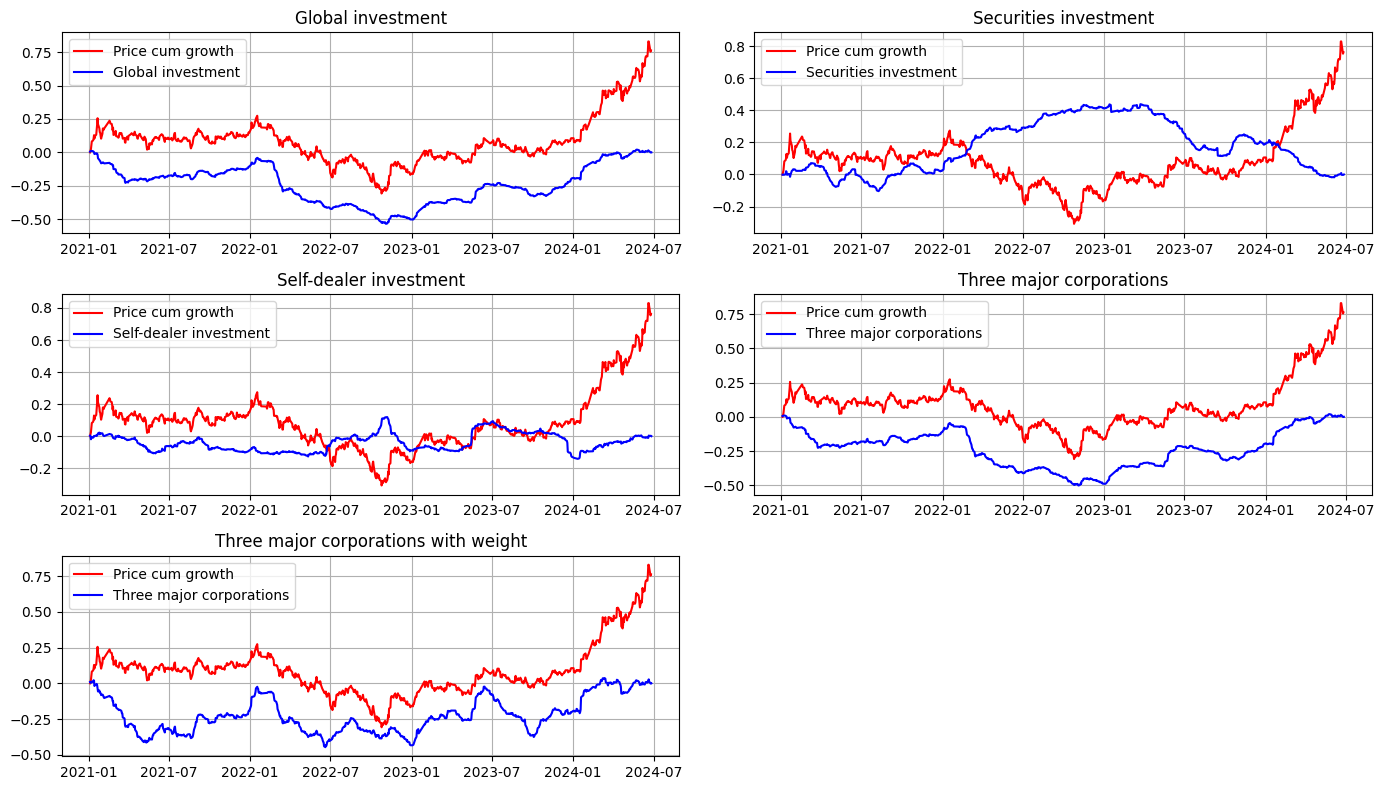

In [85]:
fig, axes = plt.subplots(3, 2, figsize=(14, 8))

axes[0, 0].plot(yf_df.index, yf_df["price_cum_growth"] , color='red', label='Price cum growth')
axes[0, 0].plot(mi_df.index, mi_df["外資累計買賣超"] , color='blue', label='Global investment')
axes[0, 0].set_title('Global investment')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(yf_df.index, yf_df["price_cum_growth"] , color='red', label='Price cum growth')
axes[0, 1].plot(mi_df.index, mi_df["投信累計買賣超"] , color='blue', label='Securities investment')
axes[0, 1].set_title('Securities investment')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(yf_df.index, yf_df["price_cum_growth"] , color='red', label='Price cum growth')
axes[1, 0].plot(mi_df.index, mi_df["自營商累計買賣超"] , color='blue', label='Self-dealer investment')
axes[1, 0].set_title('Self-dealer investment')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(yf_df.index, yf_df["price_cum_growth"] , color='red', label='Price cum growth')
axes[1, 1].plot(mi_df.index, mi_df["三大法人累計買賣超"] , color='blue', label='Three major corporations')
axes[1, 1].set_title('Three major corporations')
axes[1, 1].legend()
axes[1, 1].grid(True)

axes[2, 0].plot(yf_df.index, yf_df["price_cum_growth"] , color='red', label='Price cum growth')
axes[2, 0].plot(mi_df.index, mi_df["三大法人累計買賣超權重"] * 3 , color='blue', label='Three major corporations')
axes[2, 0].set_title('Three major corporations with weight')
axes[2, 0].legend()
axes[2, 0].grid(True)

fig.delaxes(axes[2, 1])
plt.tight_layout()
plt.show()

分析相關係數

In [87]:
def correlation(stock_df, mi_df):
    gi_cor = stock_df["price_cum_growth"].corr(mi_df['外資累計買賣超'])
    si_cor = stock_df["price_cum_growth"].corr(mi_df['投信累計買賣超'])
    sd_cor = stock_df["price_cum_growth"].corr(mi_df['自營商累計買賣超'])
    tm_cor = stock_df["price_cum_growth"].corr(mi_df['三大法人累計買賣超'])
    tmw_cor = stock_df["price_cum_growth"].corr(mi_df['三大法人累計買賣超權重'])
    print(f'Global investment Correlation: {gi_cor:.3f}')
    print(f'Securities investment Correlation: {si_cor:.3f}')
    print(f'Self-dealer Correlation: {sd_cor:.3f}')
    print(f'Three major corporations Correlation: {tm_cor:.3f}')
    print(f'Three major corporations with weight Correlation: {tmw_cor:.3f}')

In [90]:
correlation(yf_df, mi_df)

Global investment Correlation: 0.876
Securities investment Correlation: -0.653
Self-dealer Correlation: -0.091
Three major corporations Correlation: 0.880
Three major corporations with weight Correlation: 0.887
